In [34]:
#libraries:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
import re
import torch
import torch.nn as nn
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam, AdamW

In [36]:
#label: Polarity of the tweet (0 = negative, 1 = positive)
#text: Content of the tweet

df = pd.read_csv('french_tweets.csv')

In [37]:
print(df.shape)
print(df.head(15))

(1526724, 2)
    label                                               text
0       0  - Awww, c'est un bummer. Tu devrais avoir davi...
1       0  Est contrarié qu'il ne puisse pas mettre à jou...
2       0  J'ai plongé plusieurs fois pour la balle. A ré...
3       0  Tout mon corps a des démangeaisons et comme si...
4       0  Non, il ne se comporte pas du tout. je suis en...
5       0                             Pas l'équipage complet
6       0                                  besoin d'un câlin
7       0  Bonjour pas de vue! Oui ... pleut un peu, just...
8       0                          Non, ils ne l'avaient pas
9       0                                          Je meurs?
10      0  Vacances de printemps en ville ordinaire ... i...
11      0                    Je viens de perdre mes oreilles
12      0  Je ne pouvais pas supporter de le regarder. Et...
13      0  Ça compte, idk pourquoi je l'ai fait non plus....
14      0  J'aurais été le premier, mais je n'avais pas d...


In [38]:
#voir si il y a des NA:
def num_missing(x):
    return sum(x.isnull())
print("Valeurs manquantes par colonne:")
print(df.apply(num_missing, axis=0)) #axis=0 définit que la fonction sera bien appliquée sur chaque colonne

Valeurs manquantes par colonne:
label    0
text     0
dtype: int64


In [39]:
#nb textes dans chaque label:
df['label'].value_counts()

0    771604
1    755120
Name: label, dtype: int64

In [40]:
# Calculer les pourcentages pour chaque label
label_counts = df['label'].value_counts()
total_texts = df.shape[0]
percentages = label_counts / total_texts * 100
print(percentages)

0    50.539849
1    49.460151
Name: label, dtype: float64


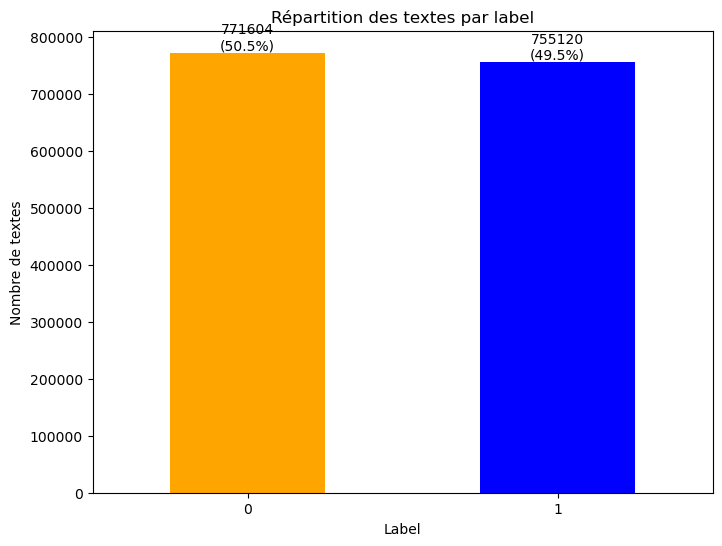

In [41]:
# Compter le nombre de textes pour chaque label
label_counts = df['label'].value_counts()

# Calculer les pourcentages pour chaque label
total_texts = df.shape[0]
percentages = label_counts / total_texts * 100

# Créer un graphique
plt.figure(figsize=(8, 6))
bars = label_counts.plot(kind='bar', color=['orange', 'blue'])

# Annoter chaque barre avec le nombre d'effectifs et le pourcentage
for i, count in enumerate(label_counts):
    plt.text(i, count, f'{count}\n({percentages[i]:.1f}%)', ha='center', va='bottom')

plt.title('Répartition des textes par label')
plt.xlabel('Label')
plt.ylabel('Nombre de textes')
plt.xticks(rotation=0)
plt.show()

In [42]:
#selectionner un nombre réduit de données pour des ressources limité (cpu)
df_sm= df.sample(n=1000)

In [43]:
df_sm[df_sm["label"]==0]

,label,text
436657,0,J'ai joué à l'un des jeux et maintenant mes co...
357225,0,Je veux entendre
585113,0,"S'il vous plaît, ne faites pas le retour de la..."
38800,0,Finalement hors de ma conférence ... n'étaient...
170847,0,"Prochain voyage ... italie, france et belgique..."
...,...,...
262976,0,Et j'essaie de m'empêcher de manger du nurofen...
726995,0,"Ils disent qu'ils ""fixés"" Moi ... je dis que ç..."
646730,0,Bahahaha. C'est tout à fait quelque chose que ...
597172,0,"Ouais, et je sors demain matin"


In [44]:
df_sm[df_sm["label"]==1]

,label,text
1230036,1,"Bhaha, au terminal de bus de viru, il y avait ..."
843124,1,"Oui, il est censé continuer à pleuvoir ce soir..."
1195409,1,Je suis prêt pour un autre jour glorieux. Allo...
1188483,1,"Merde, je dois trouver la cloche en main et bo..."
919889,1,Descendre pour trouver du dîner pour la femme ...
...,...,...
1054711,1,Rire à nouveau les smileys; jj
1096998,1,"Tout le souhait, j'aurais pu attraper ça. Mais..."
1489497,1,génial! Laissez-nous savoir comment il s'avère
851022,1,"Regarder les guerres de marié, jusqu'à présent..."


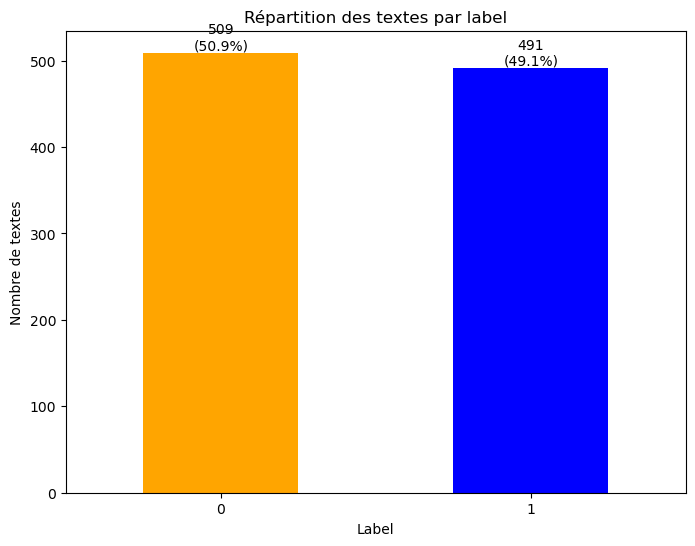

In [45]:
# Compter le nombre de textes pour chaque label
label_counts = df_sm['label'].value_counts()

# Calculer les pourcentages pour chaque label
total_texts = df_sm.shape[0]
percentages = label_counts / total_texts * 100

plt.figure(figsize=(8, 6))
bars = label_counts.plot(kind='bar', color=['orange', 'blue'])

for i, count in enumerate(label_counts):
    plt.text(i, count, f'{count}\n({percentages[i]:.1f}%)', ha='center', va='bottom')

plt.title('Répartition des textes par label')
plt.xlabel('Label')
plt.ylabel('Nombre de textes')
plt.xticks(rotation=0)
plt.show()


In [46]:
#nettoyage: supprimer les signes et les tags et les espaces vides et mettre les lettres en lowercase:
def clean_text(text):
    # lowercase
    text = text.lower()
    # remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text= re.sub(r'[@/#]', '', text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    text = re.sub(r'_+', '', text)
    # Supprime les valeurs n'étant pas dans le bon alphabet
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    #url
    text = re.sub(r'http\S+', '', text)
    # Supprime les valeurs vides
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_sm['text']=df_sm['text'].apply(clean_text)

In [47]:
df_sm

,label,text
1230036,1,bhaha au terminal de bus de viru il y avait un...
436657,0,j ai joué à l un des jeux et maintenant mes co...
843124,1,oui il est censé continuer à pleuvoir ce soir ...
357225,0,je veux entendre
585113,0,s il vous plaît ne faites pas le retour de la ...
...,...,...
851022,1,regarder les guerres de marié jusqu à présent ...
646730,0,bahahaha c est tout à fait quelque chose que j...
597172,0,ouais et je sors demain matin
153406,0,l hébergement godaddy est un peu lent pour mon...


In [48]:
#suppression d'emoji:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_sm['text']=df_sm['text'].apply(remove_emoji)

In [49]:
df_sm

,label,text
1230036,1,bhaha au terminal de bus de viru il y avait un...
436657,0,j ai joué à l un des jeux et maintenant mes co...
843124,1,oui il est censé continuer à pleuvoir ce soir ...
357225,0,je veux entendre
585113,0,s il vous plaît ne faites pas le retour de la ...
...,...,...
851022,1,regarder les guerres de marié jusqu à présent ...
646730,0,bahahaha c est tout à fait quelque chose que j...
597172,0,ouais et je sors demain matin
153406,0,l hébergement godaddy est un peu lent pour mon...


In [50]:
#voir les phrases de <= 3 tokens à supprimer ou non?

# Tokenization des textes et compter le nombre de tokens
df_sm['nb_tokens'] = df_sm['text'].apply(lambda x: len(word_tokenize(x)))

# Sélectionner les textes qui ont 3 tokens ou moins
textes_3_tokens_ou_moins = df_sm[df_sm['nb_tokens'] <=3]['text']

# Afficher les textes sélectionnés
for texte in textes_3_tokens_ou_moins:
    print(texte)
#on decide de supprimer les phrases de 2 tokens

je veux entendre
regarder pablo francisco
désolé câlins
ai je raison
j attendrais demain
happy friday tweeples
assez convenable
la nouvelle lisbonne
je sais boooo
merci mon amour
o bonjour mec
mal de tête
au workkkkk
travaux texte
suis moi thx
regarde mes jambes
avoir une bonne
bon weekend
juste moi
non vous
pas cool
ces roches fous
je suis toujours
damnit plats
tenté de rouler
où cindy
thanx null
merci bob
oooh comme ça
regarder conan obrien
au chapeau
va voir kate
woooo je ferai
oui tu fais
je suis désolé
pleut maintenant
bonne chance
mal de têtenull
impossible d attendre
straight a s
aller au lit
salut de nous
salut vagues
referat terminé
bonjour null
très très triste
ahah partyin tonight
ça fait mal
rien juste ranting
aller au travail
où est passé
fond oooohh spooky
histoire test demain
enfin parti


In [51]:
#on a decidé de supprimer les tweets de <3 car peu significatives
#tri des phrases < 3tokens:
df_sm['text'] = df_sm['text'].apply(lambda x: np.NaN if len(x.split()) < 3 else x)
df_sm.dropna(axis=0, inplace=True)

In [52]:
df_sm

,label,text,nb_tokens
1230036,1,bhaha au terminal de bus de viru il y avait un...,26
436657,0,j ai joué à l un des jeux et maintenant mes co...,14
843124,1,oui il est censé continuer à pleuvoir ce soir ...,28
357225,0,je veux entendre,3
585113,0,s il vous plaît ne faites pas le retour de la ...,20
...,...,...,...
851022,1,regarder les guerres de marié jusqu à présent ...,10
646730,0,bahahaha c est tout à fait quelque chose que j...,18
597172,0,ouais et je sors demain matin,6
153406,0,l hébergement godaddy est un peu lent pour mon...,10


In [53]:
#nb moy des tokens dans chaque tweet:

# Supposons que `tweets` est une liste contenant tous vos tweets
tweets = df_sm['text']

# Initialisation du tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenisation des tweets et calcul de la longueur (nombre de tokens) pour chaque tweet
token_lengths = [len(tokenizer.encode(tweet, add_special_tokens=True)) for tweet in tweets]

# Calcul des statistiques
max_length_tok = max(token_lengths)
min_length = min(token_lengths)
average_length = np.mean(token_lengths)

print(f"Nombre maximum de tokens dans un tweet: {max_length_tok}")
print(f"Nombre minimum de tokens dans un tweet: {min_length}")
print(f"Longueur moyenne des tokens dans les tweets: {average_length:.2f}")


Nombre maximum de tokens dans un tweet: 45
Nombre minimum de tokens dans un tweet: 5
Longueur moyenne des tokens dans les tweets: 18.43


In [54]:
#garder texte_sans_balise et nommer text:
colonne_a_supprimer=['nb_tokens']
df_sm=df_sm.drop(colonne_a_supprimer,axis=1)

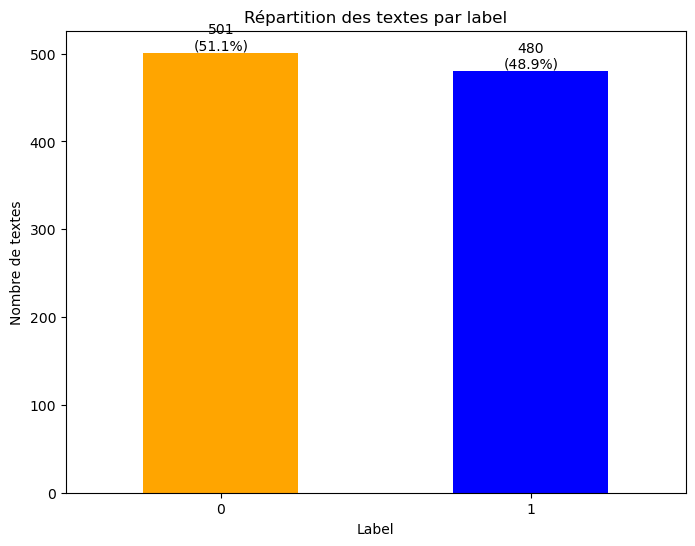

In [55]:
# Compter le nombre de textes pour chaque label
label_counts = df_sm['label'].value_counts()

# Calculer les pourcentages pour chaque label
total_texts = df_sm.shape[0]
percentages = label_counts / total_texts * 100

# Créer un graphique
plt.figure(figsize=(8, 6))
bars = label_counts.plot(kind='bar', color=['orange', 'blue'])

# Annoter chaque barre avec le nombre d'effectifs et le pourcentage
for i, count in enumerate(label_counts):
    plt.text(i, count, f'{count}\n({percentages[i]:.1f}%)', ha='center', va='bottom')

plt.title('Répartition des textes par label')
plt.xlabel('Label')
plt.ylabel('Nombre de textes')
plt.xticks(rotation=0)
plt.show()


# préparer les données pour l'entrainement:

In [56]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
#Diviser le dataset en ensembles d'entraînement, de validation, et de test.
train_df, temp_df = train_test_split(df_sm, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [58]:
#Définir une classe Dataset personnalisée pour préparer les données pour PyTorch.
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Paramètres
BATCH_SIZE = 16
#Longueur des textes
MAX_LEN = 256

# Création des instances de SentimentDataset
train_dataset = SentimentDataset(train_df['text'].to_numpy(), train_df['label'].to_numpy(), tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_df['text'].to_numpy(), val_df['label'].to_numpy(), tokenizer, MAX_LEN)
test_dataset = SentimentDataset(test_df['text'].to_numpy(), test_df['label'].to_numpy(), tokenizer, MAX_LEN)

#Créer des DataLoaders pour chaque ensemble de données, qui seront utilisés pour charger les données pendant l'entraînement.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# préparer l'entrainement

In [186]:
# Définition des hyperparamètres:
learning_rates = [5e-5, 2e-5]
optimizers= ['AdamW', 'Adam']  
schedulers = ['get_linear_schedule_with_warmup','ExponentialLR']

scheduler_params = {
    'get_linear_schedule_with_warmup': [{}],  
    'ExponentialLR': [{'gamma': 0.99}]
}

adam_params = {
    'betas': [(0.9, 0.999)],
    'eps': [1e-8]
}

adamw_params = {
    'betas': [(0.9, 0.999)],
    'eps': [1e-8],
    'weight_decay': [0.01] }


epochs = 3
total_steps = len(train_loader) * epochs
num_warmup_steps = int(total_steps * 0.2)

best_config = {}
best_global_accuracy = 0.0
best_model_weights = None


In [68]:
def train_and_evaluate(model, train_loader, validation_loader, optimizer, scheduler, epochs=epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    validation_losses = []

    best_accuracy = 0.0
    best_model_state = None
    best_epoch = -1
   

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        total_val_loss, validation_accuracy = evaluate(model, validation_loader, device)
        avg_val_loss = total_val_loss / len(validation_loader)
        validation_losses.append(avg_val_loss)

        # Mettre à jour uniquement si la précision de validation actuelle est meilleure que la meilleure précision observée jusqu'à présent
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
        


        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
        print(f"Configuration testée: LR={lr},optimizer={optimizer_name} ,Beta={beta}, Epsilon={epsilon}, Weight Decay={weight_decay}, Scheduler={scheduler_name}")
        print("-" * 80)

    return best_accuracy, best_model_state, best_epoch , train_losses, validation_losses


In [62]:
def evaluate(model, validation_loader, device):
    model.eval()
    total_val_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return total_val_loss, accuracy


In [189]:
def get_optimizer_scheduler(model, optimizer_name, lr, beta, epsilon, weight_decay, scheduler_name, num_warmup_steps, num_training_steps):
    if optimizer_name == 'Adam':
        optimizer = Adam(model.parameters(), lr=lr, betas=beta, eps=epsilon)
    elif optimizer_name == 'AdamW':
        optimizer = AdamW(model.parameters(), lr=lr, betas=beta, eps=epsilon, weight_decay=weight_decay)

    if scheduler_name == 'ExponentialLR':
        scheduler = ExponentialLR(optimizer, gamma=0.95)  
    elif scheduler_name == 'get_linear_schedule_with_warmup':
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)


    return optimizer, scheduler

# Entrainement

In [190]:
results = []

# Boucle sur les configurations d'hyperparamètres
for lr in learning_rates:
    for optimizer_name in optimizers:
        for beta in adam_params['betas']:
            for epsilon in adam_params['eps']:
                for weight_decay in adamw_params.get('weight_decay', [0]):  # Utilise [0] comme valeur par défaut si non spécifié
                    for scheduler_name in schedulers:
                        # Réinitialisation du modèle pour chaque configuration
                        model = CamembertForSequenceClassification.from_pretrained(
                            'camembert-base',
                            num_labels=2).to(device)

                        # Obtention de l'optimiseur et du scheduler pour la configuration courante
                        optimizer, scheduler = get_optimizer_scheduler(
                            model, optimizer_name, lr, beta, epsilon, weight_decay,
                            scheduler_name, num_warmup_steps, total_steps
                        )

                        # Entraînement et évaluation du modèle avec la configuration courante
                        best_accuracy, best_model_state, best_epoch,all_train_losses, all_validation_losses = train_and_evaluate(
                            model, train_loader, validation_loader, optimizer, scheduler, epochs, patience_for_early_stopping
                        )


                        # Ajout des résultats à la liste pour tableau ci-dessous
                        results.append({
                            'LR': lr,
                            'Optimizer': optimizer_name,
                            'Beta': beta,
                            'Epsilon': epsilon,
                            'Weight Decay': weight_decay,
                            'Scheduler': scheduler_name,
                            'Best Accuracy': best_accuracy,
                            'Training Losses': all_train_losses,
                            'Validation Losses': all_validation_losses,
                        })

                        # Mise à jour du meilleur modèle global si nécessaire
                        if best_accuracy > best_global_accuracy:
                            best_global_accuracy = best_accuracy
                            best_model_weights = best_model_state
                            best_config = {
                                'best_accuracy': best_accuracy,
                                'lr': lr,
                                'optimizer': optimizer_name,
                                'beta': beta,
                                'epsilon': epsilon,
                                'weight_decay': weight_decay,
                                'scheduler_name': scheduler_name,
                                'train_losses': all_train_losses,
                                'validation_losses': all_validation_losses
                            }

                            
                            
# Sauvegarde des meilleurs poids du modèle et affichage de la meilleure configuration
if best_model_weights is not None:
    torch.save(best_model_weights, 'best_model_weights.pth')
    print(f"Meilleure précision de validation globale: {best_global_accuracy}")
    print("Configuration correspondante:", best_config)
else:
    print("Aucune amélioration trouvée.")


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6839, Validation Loss: 0.6349, Validation Accuracy: 0.7595
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.5457, Validation Loss: 0.4765, Validation Accuracy: 0.7975
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.3901, Validation Loss: 0.4665, Validation Accuracy: 0.8228
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6872, Validation Loss: 0.6810, Validation Accuracy: 0.5696
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6681, Validation Loss: 0.6669, Validation Accuracy: 0.7215
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.6619, Validation Loss: 0.6649, Validation Accuracy: 0.7215
Configuration testée: LR=5e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6871, Validation Loss: 0.6317, Validation Accuracy: 0.7848
Configuration testée: LR=5e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.5541, Validation Loss: 0.4812, Validation Accuracy: 0.7848
Configuration testée: LR=5e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping triggered after epoch 2. Best epoch: 1 with accuracy 0.7848.


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6902, Validation Loss: 0.6771, Validation Accuracy: 0.6962
Configuration testée: LR=5e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6684, Validation Loss: 0.6746, Validation Accuracy: 0.6582
Configuration testée: LR=5e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping triggered after epoch 2. Best epoch: 1 with accuracy 0.6962.


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6932, Validation Loss: 0.6888, Validation Accuracy: 0.5570
Configuration testée: LR=2e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6776, Validation Loss: 0.6547, Validation Accuracy: 0.8101
Configuration testée: LR=2e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.6354, Validation Loss: 0.6109, Validation Accuracy: 0.8228
Configuration testée: LR=2e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6940, Validation Loss: 0.6884, Validation Accuracy: 0.5696
Configuration testée: LR=2e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6888, Validation Loss: 0.6884, Validation Accuracy: 0.5316
Configuration testée: LR=2e-05, Optimizer=AdamW, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping triggered after epoch 2. Best epoch: 1 with accuracy 0.5696.


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6912, Validation Loss: 0.6843, Validation Accuracy: 0.6582
Configuration testée: LR=2e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6718, Validation Loss: 0.6586, Validation Accuracy: 0.6835
Configuration testée: LR=2e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.6436, Validation Loss: 0.6371, Validation Accuracy: 0.7089
Configuration testée: LR=2e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=get_linear_schedule_with_warmup
--------------------------------------------------------------------------------


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Epoch 1/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.6936, Validation Loss: 0.6895, Validation Accuracy: 0.6329
Configuration testée: LR=2e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 2/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.6885, Validation Loss: 0.6903, Validation Accuracy: 0.6076
Configuration testée: LR=2e-05, Optimizer=Adam, Beta=(0.9, 0.999), Epsilon=1e-08, Weight Decay=0.01, Scheduler=ExponentialLR
--------------------------------------------------------------------------------


Epoch 3/3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping triggered after epoch 2. Best epoch: 1 with accuracy 0.6329.
Meilleure précision de validation globale: 0.8227848101265823
Configuration correspondante: {'best_accuracy': 0.8227848101265823, 'lr': 5e-05, 'optimizer': 'AdamW', 'beta': (0.9, 0.999), 'epsilon': 1e-08, 'weight_decay': 0.01, 'scheduler_name': 'get_linear_schedule_with_warmup', 'train_losses': [0.6838522955775261, 0.545709329098463, 0.3900749921798706], 'validation_losses': [0.6348847389221192, 0.47653392553329466, 0.4664795219898224]}


In [191]:
# Conversion de 'results' en DataFrame pour un affichage sous forme de tableau
results_df = pd.DataFrame(results)
results_df

,LR,Optimizer,Beta,Epsilon,Weight Decay,Scheduler,Best Accuracy,Training Losses,Validation Losses
0,0.00005,AdamW,"(0.9, 0.999)",1.000000e-08,0.01,get_linear_schedule_with_warmup,0.822785,"[0.6838522955775261, 0.545709329098463, 0.3900...","[0.6348847389221192, 0.47653392553329466, 0.46..."
1,0.00005,AdamW,"(0.9, 0.999)",1.000000e-08,0.01,ExponentialLR,0.721519,"[0.6871534615755082, 0.6681246280670166, 0.661...","[0.6809776544570922, 0.6668749332427979, 0.664..."
2,0.00005,Adam,"(0.9, 0.999)",1.000000e-08,0.01,get_linear_schedule_with_warmup,0.784810,"[0.6870987445116044, 0.5541303858160973, 0.390...","[0.6316707611083985, 0.4811819612979889, 0.494..."
3,0.00005,Adam,"(0.9, 0.999)",1.000000e-08,0.01,ExponentialLR,0.696203,"[0.6901566684246063, 0.6684052929282188, 0.662...","[0.6770564794540406, 0.6746486306190491, 0.673..."
4,0.00002,AdamW,"(0.9, 0.999)",1.000000e-08,0.01,get_linear_schedule_with_warmup,0.822785,"[0.6931596785783768, 0.6776052609086036, 0.635...","[0.6888203978538513, 0.6546943545341491, 0.610..."
5,0.00002,AdamW,"(0.9, 0.999)",1.000000e-08,0.01,ExponentialLR,0.569620,"[0.693953900039196, 0.688806089758873, 0.68496...","[0.6884450316429138, 0.6883666276931762, 0.688..."
6,0.00002,Adam,"(0.9, 0.999)",1.000000e-08,0.01,get_linear_schedule_with_warmup,0.708861,"[0.691212946176529, 0.671846079826355, 0.64358...","[0.684297502040863, 0.6585717916488647, 0.6371..."
7,0.00002,Adam,"(0.9, 0.999)",1.000000e-08,0.01,ExponentialLR,0.632911,"[0.6936195209622383, 0.6884674787521362, 0.687...","[0.6895143389701843, 0.6902574896812439, 0.690..."


In [192]:
print(best_config['validation_losses'])

[0.6348847389221192, 0.47653392553329466, 0.4664795219898224]


In [193]:
print(best_config['train_losses'])

[0.6838522955775261, 0.545709329098463, 0.3900749921798706]


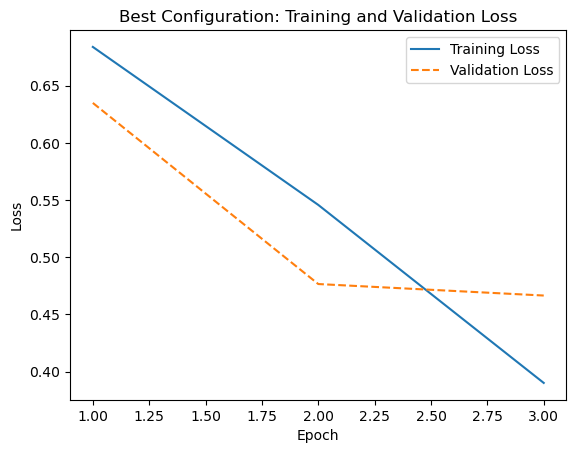

In [194]:
epochs = range(1, len(best_config['train_losses']) + 1)
plt.plot(epochs, best_config['train_losses'], label='Training Loss')
plt.plot(epochs, best_config['validation_losses'], label='Validation Loss', linestyle='--')
plt.title('Best Configuration: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# tester le modele entrainé sur des données non vues auparavant et metriques:

In [195]:
def evaluate_performance(model, test_loader, device, pos_label=1):
    model.eval()
    predictions, true_labels = [], []
    progress_bar = tqdm(test_loader, desc="Evaluating", leave=True)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).tolist())
            true_labels.extend(labels.tolist())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary', pos_label=pos_label)
    accuracy = accuracy_score(true_labels, predictions)
    confusion = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (for class {pos_label}): {precision:.4f}')
    print(f'Recall (for class {pos_label}): {recall:.4f}')
    print(f'F1 Score (for class {pos_label}): {f1:.4f}')

    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 0.6709
Precision (for class 1): 0.6364
Recall (for class 1): 0.9545
F1 Score (for class 1): 0.7636


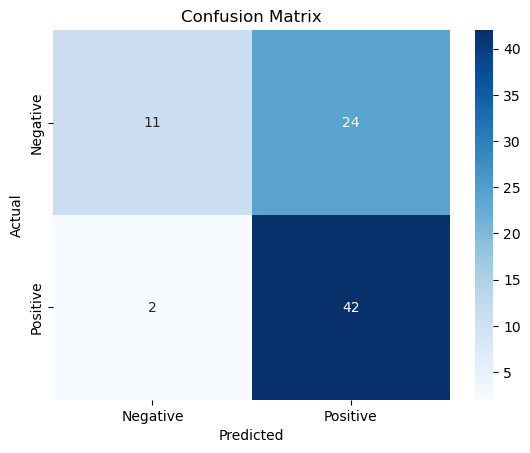

In [196]:
evaluate_performance(model, test_loader, device)
